In [1]:
%cd src/
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet50, resnet101, resnet34, resnet18
from torch.autograd import Variable
import torchvision
from data import preproc as pp
from data import evaluation
from torch.utils.data import Dataset
import time
import timm
import torch



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=128):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class OCR(nn.Module):

    def __init__(self, vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers):
        super().__init__()
    
#         self.backbone = timm.create_model('ecaresnet101d', pretrained=True,)
#         del self.backbone.fc
        self.backbone = timm.create_model('resnest101e', pretrained=False)
#         self.backbone = timm.create_model('resnest101e', pretrained=args.pretrained)
        del self.backbone.fc
#         for name,p in self.backbone.named_parameters():
#             if "bn" not in name or "attnpool" in name:
#                 p.requires_grad =  FalseFalse

        # create a default PyTorch transformer
        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads with length of vocab
        # DETR used basic 3 layer MLP for output
        self.vocab = nn.Linear(hidden_dim,vocab_len)

        # output positional encodings (object queries)
        self.decoder = nn.Embedding(vocab_len, hidden_dim)
        self.query_pos = PositionalEncoding(hidden_dim, .2)

        # spatial positional encodings, sine positional encoding can be used.
        # Detr baseline uses sine positional encoding.
        self.row_embed = nn.Parameter(torch.rand(90, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(90, hidden_dim // 2))
        self.trg_mask = None
  
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask
    
#     def get_feature(self,x):
#             x = self.backbone.conv_stem(x)
#             x = self.backbone.bn1(x)   
#             x = self.backbone.act1(x)
#             x = self.backbone.blocks(x)
#             return x

    def get_feature(self,x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)   
        x = self.backbone.act1(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        return x

#     def get_feature(self, x):
#         x = self.backbone.forward_features(x)
#         return x


    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)


    def forward(self, inputs, trg):
        # propagate inputs through ResNet-101 up to avg-pool layer
        x = self.get_feature(inputs)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        bs,_,H, W = h.shape
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # generating subsequent mask for target
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(trg.shape[1]).to(trg.device)

        # Padding mask
        trg_pad_mask = self.make_len_mask(trg)

        # Getting postional encoding for target
        trg = self.decoder(trg)
        trg = self.query_pos(trg)
        
        output = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), trg.permute(1,0,2), tgt_mask=self.trg_mask, 
                                  tgt_key_padding_mask=trg_pad_mask.permute(1,0))

        return self.vocab(output.transpose(0,1))


def make_model(vocab_len, hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4):
    
    return OCR(vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers)

"""
Uses generator functions to supply train/test with data.
Image renderings and text are created on the fly each time.
"""

class DataGenerator(Dataset):
    """Generator class with data streaming"""

    def __init__(self, source, split, transform, tokenizer):
        self.tokenizer = tokenizer
        self.transform = transform
        
        self.split = split
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            self.dataset[self.split] = dict()

            self.dataset[self.split]['dt'] = np.array(f[self.split]['dt'])
            self.dataset[self.split]['gt'] = np.array(f[self.split]['gt'])
          
            randomize = np.arange(len(self.dataset[self.split]['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset[self.split]['dt'] = self.dataset[self.split]['dt'][randomize]
            self.dataset[self.split]['gt'] = self.dataset[self.split]['gt'][randomize]

            # decode sentences from byte
            self.dataset[self.split]['gt'] = [x.decode() for x in self.dataset[self.split]['gt']]
            
        self.size = len(self.dataset[self.split]['gt'])


    def __getitem__(self, i):
        img = self.dataset[self.split]['dt'][i]
        
        #making image compatible with resnet
#         img = cv2.transpose(img)
        img = np.repeat(img[..., np.newaxis],3, -1).astype("float32")   
#         img = pp.normalization(img).astype("float32")

        if self.transform is not None:
            aug = self.transform(image=img)
            img = aug['image']
            
#             img = self.transform(img)
            
        y_train = self.tokenizer.encode(self.dataset[self.split]['gt'][i]) 
        
        #padding till max length
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt          

    def __len__(self):
      return self.size

class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""
        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""
        
        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = pp.text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")

/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/src


In [3]:
import os
import datetime
import string

batch_size = 16
epochs = 200

# define paths
#change paths accordingly
source = 'rimes'
source_path = '../data/{}.hdf5'.format(source)
output_path = os.path.join("..", "output", source)
target_path = os.path.join(output_path, "checkpoint_weights_iam_{}.hdf5".format("dsa"))
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]
# charset_base = string.printable[:36].lower() + string.printable[36+26:95].lower() 

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

import torchvision.transforms as T
local_rank = 3
device = torch.device("cuda:{}".format(local_rank))

# transform = T.Compose([
#     T.ToTensor()])
tokenizer = Tokenizer(charset_base)
import albumentations
import albumentations.pytorch



transform_valid = albumentations.Compose(
    [
        albumentations.Normalize(),
        albumentations.pytorch.ToTensorV2()
    ]
)

source: ../data/rimes.hdf5
output ../output/rimes
target ../output/rimes/checkpoint_weights_iam_dsa.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [3]:
img = torch.rand(1,3,1024,128).to("cuda:3")
trg = torch.randint(1,5,(1,128)).to("cuda:3")

In [20]:
%%time
x = model(img,trg)

CPU times: user 246 ms, sys: 25.1 ms, total: 271 ms
Wall time: 74.9 ms


In [4]:
tokenizer = Tokenizer(charset_base)

In [5]:
model = make_model( vocab_len=tokenizer.vocab_size,hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4)

_ = model.to(device)

In [7]:
model_name = "absurd-shape-197"
databse = source

In [8]:
d = torch.load("/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/output/{}/{}_first_100.pt".format(model_name,databse), map_location="cuda:2")
d1 = torch.load("/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/output/{}/{}_first_180.pt".format(model_name,databse), map_location="cuda:2")
# d2 = torch.load("/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/output/{}/{}_first_50.pt".format(model_name,databse), map_location="cuda:2")


In [9]:
beta = 0.5 #The interpolation parameter    
params1 = d
params2 = d1
 
dict_params2 = params2
 
for name1, param1 in params1.items():
    if name1 in dict_params2:
        dict_params2[name1].data.copy_(beta*param1.data + (1-beta)*dict_params2[name1].data)

In [10]:
# beta = 0.5 #The interpolation parameter    
# params1 = d
# params2 = d1
# param3 = d2
 
# dict_params2 = params2
 
# for name1, param1 in params1.items():
#     if name1 in dict_params2:
#         dict_params2[name1].data.copy_(.3*param1.data + (.3*dict_params2[name1].data) + (.4*param3[name1].data))

In [11]:
model.load_state_dict(dict_params2)

<All keys matched successfully>

In [17]:
d1 = torch.load("/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/output/{}/{}_firstbest_loss.pt".format(model_name,databse), map_location="cuda:2")
model.load_state_dict(d1)

<All keys matched successfully>

In [12]:
def get_memory(model,imgs):
    x = model.conv(model.get_feature(imgs))
    bs,_,H, W = x.shape
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    return model.transformer.encoder(pos +  0.1 * x.flatten(2).permute(2, 0, 1))
    

def test(model, test_loader, max_text_length):
    model.eval()
    predicts = []
    gt = []
    imgs = []
    c=0
    with torch.no_grad():
        for batch in test_loader:
            src, trg = batch
            imgs.append(src.flatten(0,1))
            src, trg = src.to(device), trg.to(device)    
            memory = get_memory(model,src.float())
            out_indexes = [tokenizer.chars.index('SOS'), ]
            for i in range(max_text_length):
                mask = model.generate_square_subsequent_mask(i+1).to(device)
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model.vocab(model.transformer.decoder(model.query_pos(model.decoder(trg_tensor)), memory,tgt_mask=mask))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == tokenizer.chars.index('EOS'):
                    break
            predicts.append(tokenizer.decode(out_indexes))
            gt.append(tokenizer.decode(trg.flatten(0,1)))
#             if c==2:
#                 break
            c+=1
    return predicts, gt, imgs

In [13]:
test_loader = torch.utils.data.DataLoader(DataGenerator(source_path,'test',transform_valid, tokenizer), batch_size=1, shuffle=False, num_workers=6)

In [18]:
%%time
predicts, gt, imgs = test(model,test_loader , max_text_length)

CPU times: user 1h 14min 25s, sys: 6.72 s, total: 1h 14min 32s
Wall time: 5min 31s


In [19]:
predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)

In [16]:
evaluate

array([0.04660927, 0.13418334, 0.51750973])

In [20]:
evaluate

array([0.04862405, 0.13850283, 0.54345006])

In [101]:
evaluate

array([0.05257591, 0.1263285 , 0.52386935])

In [38]:
evaluate

array([0.80173698, 0.93165775, 1.        ])

In [43]:
evaluate

array([0.72955912, 0.90681278, 1.        ])

In [126]:
from PIL import Image, ImageOps
import numpy as np

In [196]:
im = cv2.imread("../raw/washington/data/line_images_normalized/270-20.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


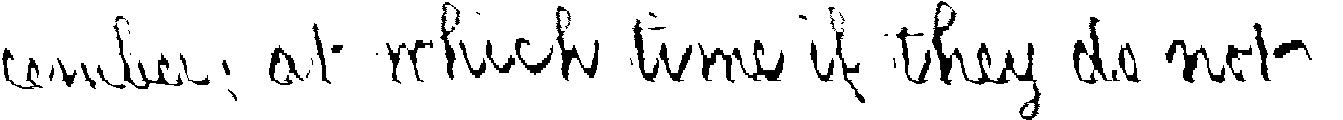

In [197]:
Image.fromarray(im)

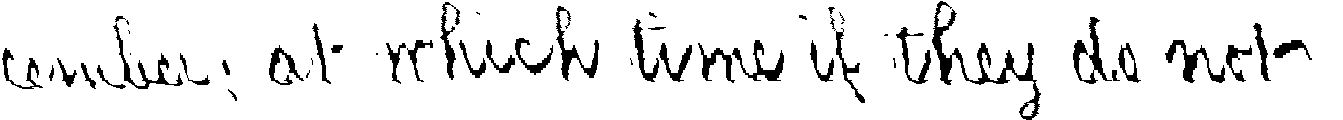

In [199]:
a = pp.illumination_compensation(np.array(im))
Image.fromarray(a)

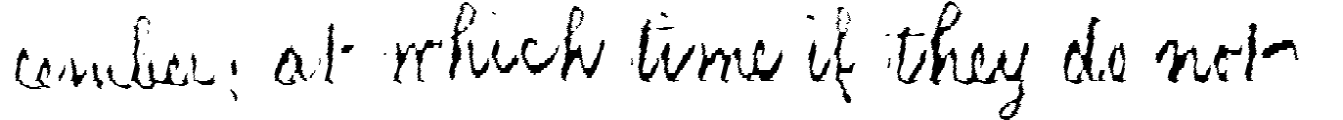

In [200]:
Image.fromarray(pp.remove_cursive_style(a))

In [70]:
img = pp.preprocess("../raw/iam/lines/b01/b01-000/b01-000-00.png", input_size=(1024,128,1))

In [164]:
def pre(path, input_size):
    img = cv2.imread(path,)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    wt, ht, _ = input_size
    h, w = img.shape
    f = max((w / wt), (h / ht))
    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    img = cv2.resize(img, new_size)
    img = pp.illumination_compensation(img)
    img = pp.remove_cursive_style(img)
    img = cv2.resize(img, new_size)
    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    return target

In [165]:
img = pre("../raw/bentham/BenthamDatasetR0-GT/Images/Lines/002_080_001_03_05.png", input_size=(1024,128,1))

In [30]:
dataset = {}
with h5py.File("../data/bentham.hdf5", "r") as f:
    dataset["valid"] = dict()

    dataset["valid"]['dt'] = np.array(f["valid"]['dt'])
    dataset["valid"]['gt'] = np.array(f["valid"]['gt'])


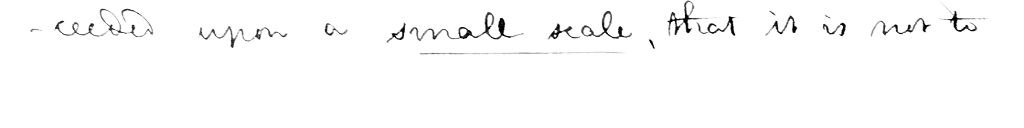

In [39]:
Image.fromarray(cv2.transpose(np.repeat(dataset["valid"]['dt'][35][..., np.newaxis],3, -1) ))

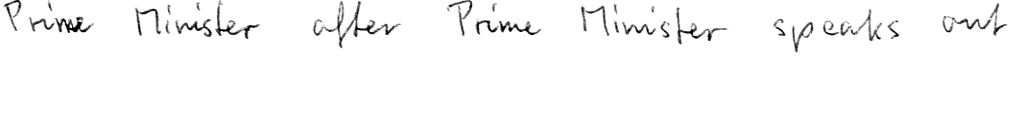

In [73]:
Image.fromarray(cv2.transpose(img))

In [ ]:
cv2.transpose(img)

In [13]:
import json
# with open("pre.json","w") as f:
#     json.dump(less+ more, f)
    
with open("pre.json","r") as f:
    a= json.load(f)

In [77]:
1542//2

771

In [14]:
less = a[:771]

In [14]:
more = a[771:]

In [37]:
source = "../data/rimes.hdf5"
split = "train"

In [38]:
dataset = dict()

with h5py.File(source, "r") as f:
    dataset[split] = dict()

    dataset[split]['dt'] = np.array(f[split]['dt'])
    dataset[split]['gt'] = np.array(f[split]['gt'])

    randomize = np.arange(len(dataset[split]['gt']))
    np.random.seed(42)
    np.random.shuffle(randomize)

    dataset[split]['dt'] = dataset[split]['dt'][randomize]
    dataset[split]['gt'] = dataset[split]['gt'][randomize]

    # decode sentences from byte
    dataset[split]['gt'] = [x.decode() for x in dataset[split]['gt']]


In [41]:
len(dataset[split]['dt'])

10114

In [22]:
from PIL import Image

In [41]:
for i,v in enumerate(dataset[split]['gt']):
    if "ne quantite importante de" in unicodedata.normalize("NFKD", v).encode("ASCII", "ignore").decode("ASCII"):
        print(i)
#     Image.fromarray(cv2.transpose(dataset["test"]["dt"][1]))

761


In [48]:
gt[769], predicts[769]

('le revenu . Je souhaite , a partir de ce jour , opter pour',
 'le revenu . Je souhaite , a partir de ce jour , opter pour')

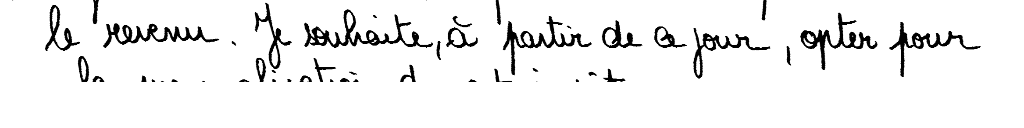

In [46]:
Image.fromarray(cv2.transpose(dataset["test"]["dt"][769]))

In [39]:
tokenizer.encode('ai réglé régulièrement les intérêts .')

array([ 2, 14, 22, 98, 31, 18, 20, 25, 18, 98, 31, 18, 20, 34, 25, 22, 18,
       31, 18, 26, 18, 27, 33, 98, 25, 18, 32, 98, 22, 27, 33, 18, 31, 18,
       33, 32, 98, 79,  3])

In [40]:
tokenizer.decode([ 2, 14, 22, 98, 31, 18, 20, 25, 18, 98, 31, 18, 20, 34, 25, 22, 18,
       31, 18, 26, 18, 27, 33, 98, 25, 18, 32, 98, 22, 27, 33, 18, 31, 18,
       33, 32, 98, 79,  3])

'SOSai regle regulierement les interets . EOS'

In [69]:
img = cv2.imread("../raw/iam/lines/b01/b01-000/b01-000-00.png")

In [70]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [65]:
img.shape, gray.shape

((140, 1856, 3), (140, 1856))

In [58]:
im = pp.preprocess("../raw/iam/lines/a04/a04-000/a04-000-00.png", (1024, 128, 1))

In [71]:
imm = pp.remove_cursive_style(gray)

In [72]:
cv2.imwrite("temp.png",imm)

True

In [54]:
im.shape

(1024, 128)

In [19]:
from torchvision.models import resnet50, resnet34, resnet18

r = resnet18(pretrained=True)

In [23]:
    def get_feature(backbone, x):
        x = backbone.conv1(x)
        x = backbone.bn1(x)   
        x = backbone.relu(x)
        x = backbone.maxpool(x)

        x = backbone.layer1(x)
        x = backbone.layer2(x)
        x = backbone.layer3(x)
        x = backbone.layer4(x)
        return x


In [24]:
a = torch.rand(1,3,1024,128)

In [25]:
get_feature(r,a).shape

torch.Size([1, 512, 32, 4])